9. This question uses the variables `dis` (the weighted mean of distances to five Boston employment centers) and `nox` (nitrogen oxides concentration in parts per 10 million) from the `Boston` data. 
We will treat `dis` as the predictor and `nox` as the response.

In [98]:
library("ISLR2")
library("skimr")
library("ggplot2")
library("splines")
library("gam")
library("akima")
library("patchwork")
library("boot")

In [3]:
head(Boston)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
2,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
3,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
4,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
5,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
6,0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,5.21,28.7


In [4]:
skim(Boston)

── Data Summary ────────────────────────
                           Values
Name                       Boston
Number of rows             506   
Number of columns          13    
_______________________          
Column type frequency:           
  numeric                  13    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable n_missing complete_rate     mean      sd        p0      p25
 1 crim                  0             1   3.61     8.60    0.00632   0.0820
 2 zn                    0             1  11.4     23.3     0         0     
 3 indus                 0             1  11.1      6.86    0.46      5.19  
 4 chas                  0             1   0.0692   0.254   0         0     
 5 nox                   0             1   0.555    0.116   0.385     0.449 
 6 rm                    0             1   6.28     0.703   3.56      5.89  
 7 age                   0      

In [5]:
colSums(is.na(Boston))

crim      zn   indus    chas     nox      rm     age     dis     rad     tax 
      0       0       0       0       0       0       0       0       0       0 
ptratio   lstat    medv 
      0       0       0

(a) Use the `poly()` function to fit a cubic polynomial regression to predict `nox` using `dis`. 
Report the regression output, and plot the resulting data and polynomial fits.


In [6]:
poly_fit_cubic <- lm(
    nox ~ poly(dis, 3),
    data = Boston
)

summary(poly_fit_cubic)


Call:
lm(formula = nox ~ poly(dis, 3), data = Boston)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.121130 -0.040619 -0.009738  0.023385  0.194904 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.554695   0.002759 201.021  < 2e-16 ***
poly(dis, 3)1 -2.003096   0.062071 -32.271  < 2e-16 ***
poly(dis, 3)2  0.856330   0.062071  13.796  < 2e-16 ***
poly(dis, 3)3 -0.318049   0.062071  -5.124 4.27e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06207 on 502 degrees of freedom
Multiple R-squared:  0.7148,	Adjusted R-squared:  0.7131 
F-statistic: 419.3 on 3 and 502 DF,  p-value: < 2.2e-16


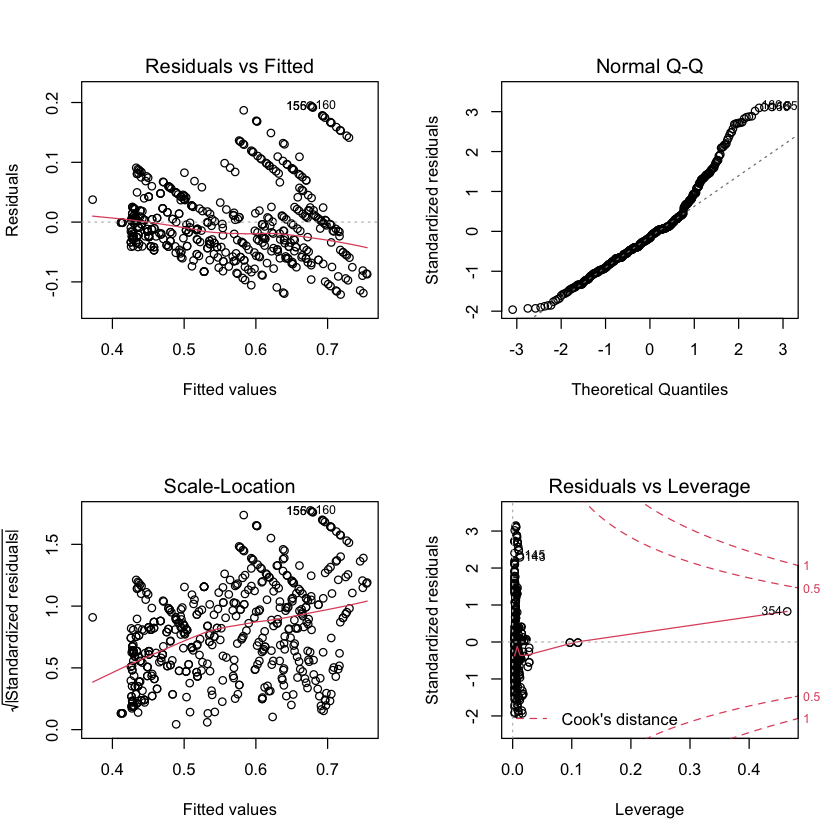

In [7]:
par(mfrow = c(2, 2))
plot(poly_fit_cubic)

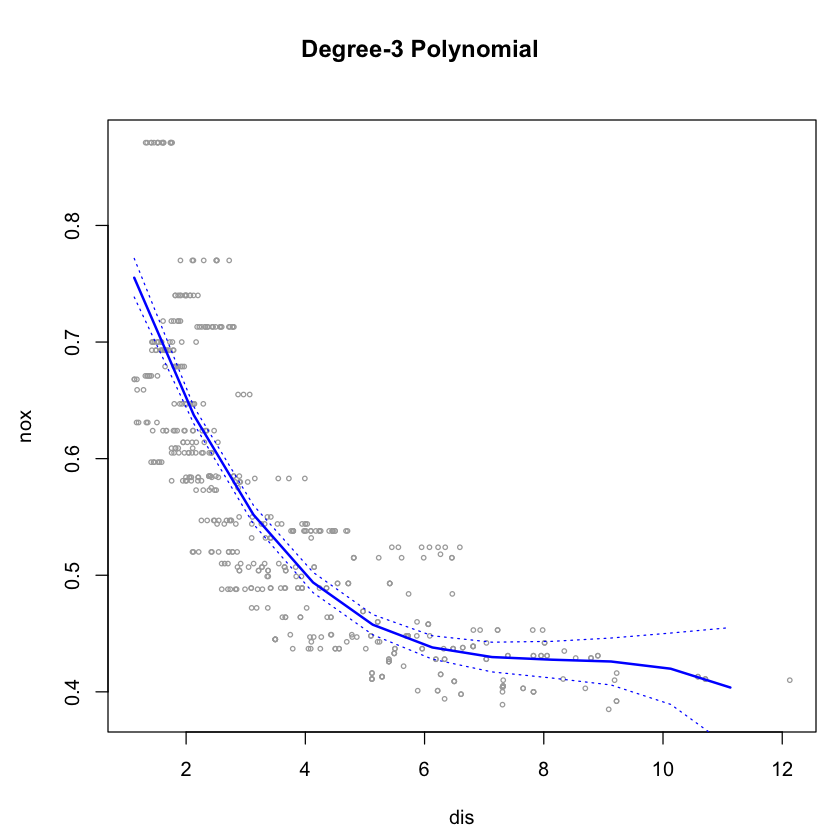

In [12]:
limits <- range(Boston$dis)
grids <- seq(from = limits[1], to = limits[2])

preds <- predict(poly_fit_cubic, newdata = list(dis = grids), se = T)
se_bands <- cbind(
    preds$fit + 2.0 * preds$se.fit,
    preds$fit - 2.0 * preds$se.fit
)

par(mfrow = c(1, 1), mar = c(4.5, 4.5, 1, 1), oma = c(0, 0, 4, 0))
plot(Boston$dis, Boston$nox, xlim = limits, cex = .5, col = "darkgrey", xlab = "dis", ylab = "nox")
title("Degree-3 Polynomial", outer = T)
lines(grids, preds$fit, lwd = 2, col = "blue")
matlines(grids, se_bands, lwd = 1, col = "blue", lty = 3)

(b) Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10), and report the associated residual sum of squares.

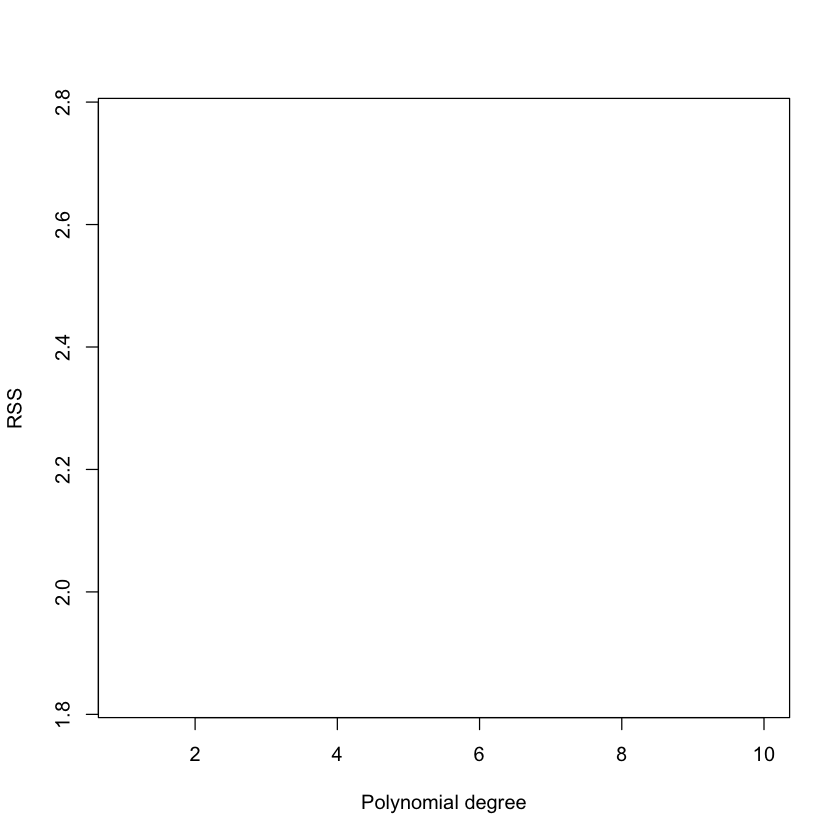

In [23]:
rss <- numeric(length = 10)
for (i in 1:10) {
    fit <- lm(nox ~ poly(dis, i), data = Boston)
    rss[i] <- sum(summary(fit)$residuals^2)
}

plot(
    rss,
    xlab = "Polynomial degree",
    ylab = "RSS",
    type = "l",
    col = "white")

(c) Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results.


Let's try cross-validation:

In [26]:
set.seed(1)
NUM_POLY <- 10
cv_error <- numeric(length = NUM_POLY)
for (i in seq(NUM_POLY)) {
    glm_fit <- glm(nox ~ poly(dis, i), data = Boston)
    cv_error[i] <- cv.glm(Boston, glm_fit, K = 10)$delta[1]
}
print(round(cv_error, 5))

 [1] 0.00556 0.00409 0.00388 0.00386 0.00424 0.00569 0.01028 0.00681 0.03331
[10] 0.00408


In [27]:
which.min(cv_error)

[1] 4

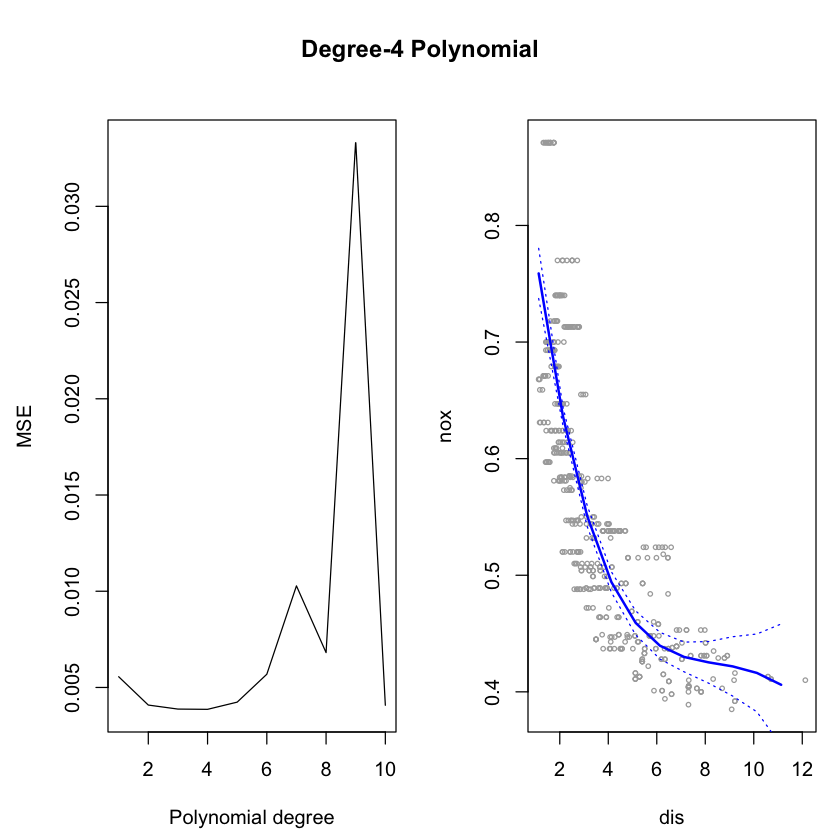

In [34]:
par(mfrow = c(1, 2), mar = c(4.5, 4.5, 1, 1), oma = c(0, 0, 4, 0))

plot(
    cv_error,
    type = "l",
    xlab = "Polynomial degree",
    ylab = "MSE"
)

glm_fit <- glm(nox ~ poly(dis, 4), data = Boston)
preds <- predict(glm_fit, newdata = list(dis = grids), se = T)
se_bands <- cbind(
    preds$fit + 2.0 * preds$se.fit,
    preds$fit - 2.0 * preds$se.fit
)

#par(mfrow = c(1, 1), mar = c(4.5, 4.5, 1, 1), oma = c(0, 0, 4, 0))
plot(Boston$dis, Boston$nox, xlim = limits, cex = .5, col = "darkgrey", xlab = "dis", ylab = "nox")
title("Degree-4 Polynomial", outer = T)
lines(grids, preds$fit, lwd = 2, col = "blue")
matlines(grids, se_bands, lwd = 1, col = "blue", lty = 3)

Now let's see the ANOVA analysis:

In [32]:
fit_anova <- list()
for (i in seq(NUM_POLY)) {
    fit_anova[[i]] <- lm(nox ~ poly(dis, i), data = Boston)
}

In [33]:
print(anova(
    fit_anova[[1]],
    fit_anova[[2]],
    fit_anova[[3]],
    fit_anova[[4]],
    fit_anova[[5]],
    fit_anova[[6]],
    fit_anova[[7]],
    fit_anova[[8]],
    fit_anova[[9]],
    fit_anova[[10]]
))

Analysis of Variance Table

Model  1: nox ~ poly(dis, i)
Model  2: nox ~ poly(dis, i)
Model  3: nox ~ poly(dis, i)
Model  4: nox ~ poly(dis, i)
Model  5: nox ~ poly(dis, i)
Model  6: nox ~ poly(dis, i)
Model  7: nox ~ poly(dis, i)
Model  8: nox ~ poly(dis, i)
Model  9: nox ~ poly(dis, i)
Model 10: nox ~ poly(dis, i)
   Res.Df    RSS Df Sum of Sq        F    Pr(>F)    
1     504 2.7686                                    
2     503 2.0353  1   0.73330 198.1169 < 2.2e-16 ***
3     502 1.9341  1   0.10116  27.3292 2.535e-07 ***
4     501 1.9330  1   0.00113   0.3040  0.581606    
5     500 1.9153  1   0.01769   4.7797  0.029265 *  
6     499 1.8783  1   0.03703  10.0052  0.001657 ** 
7     498 1.8495  1   0.02877   7.7738  0.005505 ** 
8     497 1.8356  1   0.01385   3.7429  0.053601 .  
9     496 1.8333  1   0.00230   0.6211  0.431019    
10    495 1.8322  1   0.00116   0.3133  0.575908    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


According to the cross-validation process, the 4th degree polynomial seems to be the best option in terms of MSE. As per the ANOVA method, the $p$-values suggest that a 7th degree polynomial would be the best option.

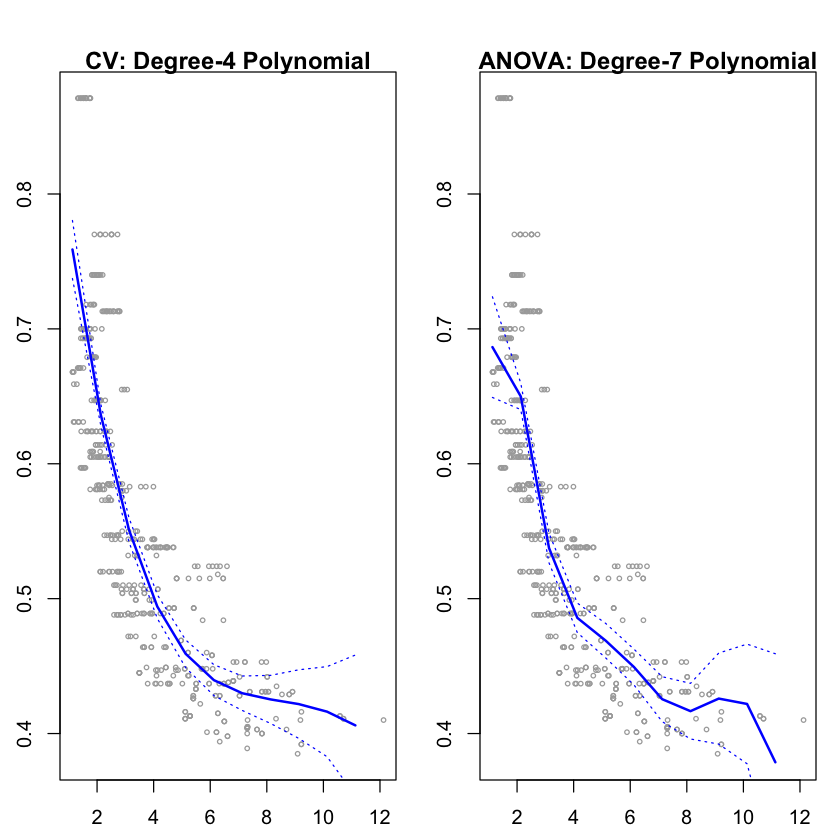

In [37]:
par(mfrow = c(1, 2), mar = c(4.5, 4.5, 1, 1), oma = c(0, 0, 4, 0))

glm_fit <- glm(nox ~ poly(dis, 4), data = Boston)
preds <- predict(glm_fit, newdata = list(dis = grids), se = T)
se_bands <- cbind(
    preds$fit + 2.0 * preds$se.fit,
    preds$fit - 2.0 * preds$se.fit
)

plot(Boston$dis, Boston$nox, xlim = limits, cex = .5, col = "darkgrey", xlab = "dis", ylab = "nox")
title("CV: Degree-4 Polynomial", outer = F)
lines(grids, preds$fit, lwd = 2, col = "blue")
matlines(grids, se_bands, lwd = 1, col = "blue", lty = 3)

glm_fit <- glm(nox ~ poly(dis, 7), data = Boston)
preds <- predict(glm_fit, newdata = list(dis = grids), se = T)
se_bands <- cbind(
    preds$fit + 2.0 * preds$se.fit,
    preds$fit - 2.0 * preds$se.fit
)

plot(Boston$dis, Boston$nox, xlim = limits, cex = .5, col = "darkgrey", xlab = "dis", ylab = "nox")
title("ANOVA: Degree-7 Polynomial", outer = F)
lines(grids, preds$fit, lwd = 2, col = "blue")
matlines(grids, se_bands, lwd = 1, col = "blue", lty = 3)

Although the ANOVA method suggests $d=7$, we can see from the plots above that the model would tend to overfit new data with that fit (too wiggly).

On the other hand, the $d=4$ that results from the CV process seems more appropriate.

(d) Use the `bs()` function to fit a regression spline to predict `nox` using `dis`. 
Report the output for the fit using four degrees of freedom. 
How did you choose the knots? Plot the resulting fit.

Let's choose the knots to be the percentiles of the `dis` predictor:

In [39]:
print(attr(bs(Boston$dis, df = 6), "knots"))

     25%      50%      75% 
2.100175 3.207450 5.188425 


In [41]:
bs_fit <- lm(
    nox ~ bs(dis, knots = c(2.1, 3.2, 5.2)),
    data = Boston
)

pred <- predict(bs_fit, newdata = list(dis = grids), se = T)

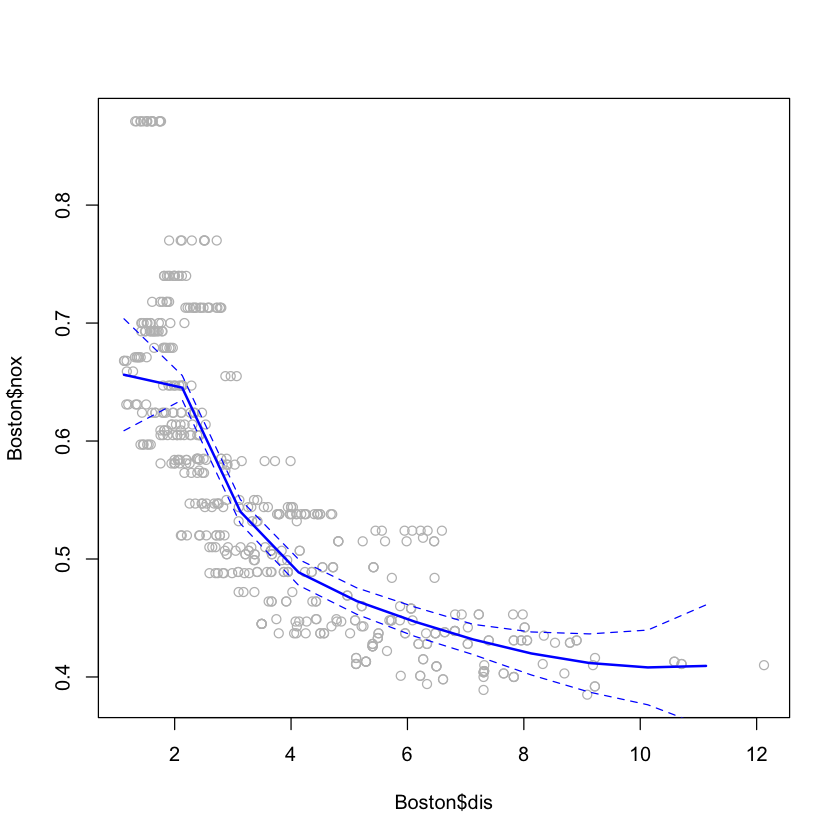

In [43]:
plot(Boston$dis, Boston$nox, col = "gray")
lines(grids, pred$fit, lwd = 2, col = "blue")
lines(grids, pred$fit + 2.0 * pred$se, lty = "dashed", col = "blue")
lines(grids, pred$fit - 2.0 * pred$se, lty = "dashed", col = "blue")

(e) Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting RSS. Describe the results obtained.

In [58]:
DEG_FREEDOM <- 10
rss <- numeric(length = DEG_FREEDOM)
pred_fit <- matrix(NA, nrow = length(grids), ncol = DEG_FREEDOM)
for (i in 3:DEG_FREEDOM) {
    fit <- lm(nox ~ bs(dis, df = i), data = Boston)
    pred_fit[, i] <- predict(fit, newdata = list(dis = grids), se = F)# $fit
    rss[i] <- sum(residuals(summary(fit))^2)
}

rss <- rss[3:DEG_FREEDOM]

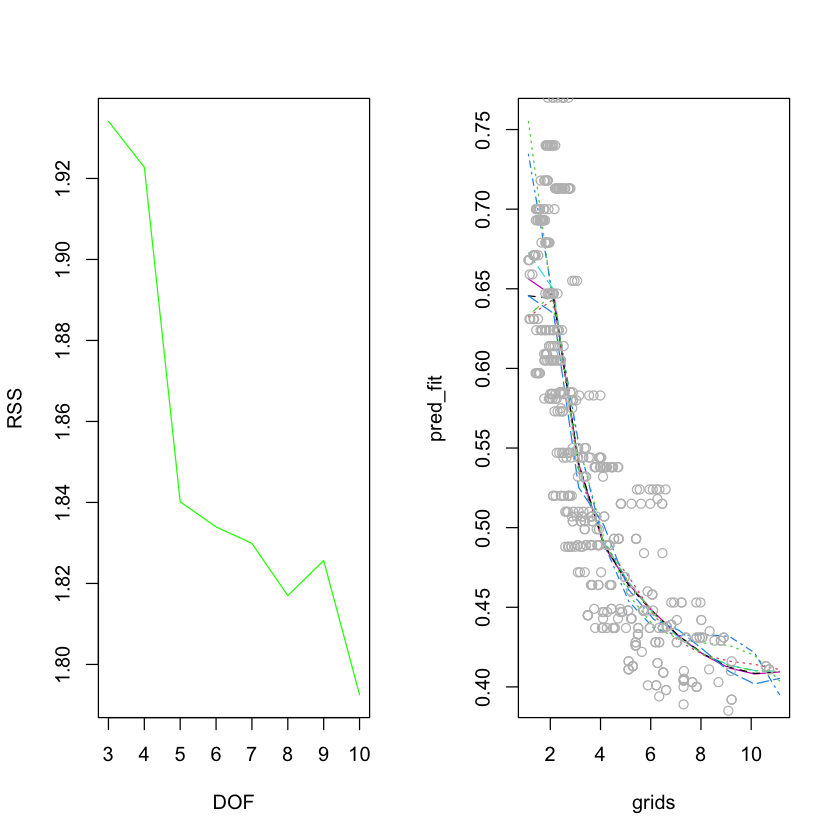

In [101]:
par(mfrow = c(1, 2))
plot(seq(rss) + 2, rss, type = "l", col = "green", xlab = "DOF", ylab = "RSS")
matplot(grids, pred_fit, type = "l")
points(Boston$dis, Boston$nox, col = "gray")

The best DOF in terms of RSS for the `dis` predictor regressing `nox` is 10. Although this might overfit.